# Bayesian inference

## [Scientific Computing with Python](http://scicompy.yoavram.com)
## Yoav Ram

In [610]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize
import emcee # conda install emcee
import seaborn as sns
sns.set_context('talk')

red, blue, green = sns.color_palette('Set1', 3)


Bayesian inference is a method of statistical inference in which Bayes' theorem is used to update the probability for a hypothesis as more evidence or information becomes available. 

**Bayes' theorem**.
Consider the events $A$ and $B$, then Bayes' theorem states that

$$
P(A \mid B) = \frac{P(B \mid A) P(A)}{P(B)}
$$

Applied to model-based inference, we define:
- $\theta$ are the model parameters
- $X$ are the data
and we have
$$
P(\theta \mid X) = \frac{P(X \mid \theta) P(\theta)}{P(X)}
$$
where
- $P(\theta)$ is called the *prior probability* that formulates our beliefs about the model before seeing any data
- $P(X \mid \theta)$ is the probability of observing $X$ given $\theta$, what we called the *likelihood of $\theta$*
- $P(\theta \mid X)$ is called the *posterior probability*, that is, how our beliefs about the model changed due to observing the data
- $P(X)$ is the probability of observing the data unconditioned on the model; we usually ignore it as it does not depend on the model

In Bayesian inference we attempt to estimate the posterior distribution over the model parameters; this constrast with classical/frequentist approaches like *maximum likelihood* in which we attempt to estimate a point estimate of the parameters - a single parameter value.

# Simple model for photon counts

This example follows a [blog post by Jake VanDerPlas](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/).

Imagine that we point our telescope to the sky, and observe the light coming from a single star. For the time being, we'll assume that the star's true flux is constant with time, i.e. that is it has a fixed value $F_{\rm true}$ (we'll also ignore effects like sky noise and other sources of systematic error). We'll assume that we perform a series of $N$ measurements with our telescope, where the $i^{\rm th}$ measurement reports the observed photon flux $F_i$ and error $e_i$.

The question is, given this set of measurements $D = \{F_i,e_i\}$, what is our best estimate of the true flux $F_{\rm true}$?

We start by generating some data.

In [611]:
np.random.seed(1)

# true flux: number of photons measured in 1 second
F_true = 1000  
# number of measurements
N = 50 
# N measurements of the flux
F = scipy.stats.poisson(F_true).rvs(N)  
# errors estimated via square root: expectation=variance in Poisson
e = np.sqrt(F)  

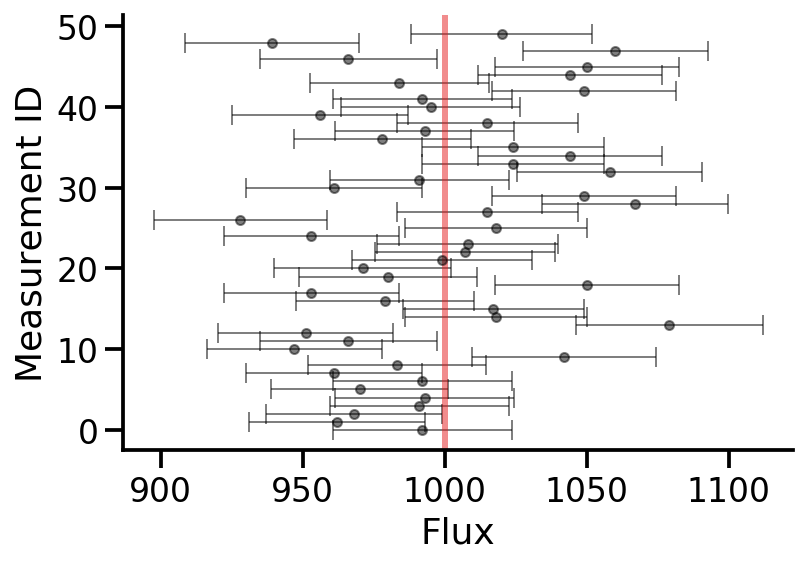

In [612]:
plt.errorbar(F, np.arange(N), xerr=e, fmt='.k',capsize=5, ecolor='k', linewidth=1, alpha=0.5)
plt.axvline(F_true, linewidth=3, alpha=0.5, color=red)
plt.xlabel("Flux")
plt.ylabel("Measurement ID")
sns.despine()

In this toy example we already know the
true flux $F_{\rm true}$, but the question is this: **given our measurements and errors, what is our best estimate of the true flux?**

## Frequentist approach

We'll make the reasonable assumption that measurement errors are Gaussian.

Given a single observation $D_i = (F_i, e_i)$, we can compute the probability distribution of the measurement given the true flux $F_{\rm true}$ given our assumption of Gaussian errors:

$$
P(D_i~|~F_{\rm true}) = 
\frac{1}{\sqrt{2\pi e_i^2}} \exp{\left[\frac{-(F_i - F_{\rm true})^2}{2 e_i^2}\right]}
$$

We construct the **likelihood function** by computing the product of the probabilities for each data point:

$$
\mathcal{L}(\hat{F}~|~D) = 
\prod_{i=1}^N P(D_i~|~\hat{F})
$$
where $D = \{D_i\}_{i=1}^N$.

The likelihood is a product of exponents, so we take the log-likelihood:

$$
\log\mathcal{L}(\hat{F}) = 
-\frac{1}{2} \sum_{i=1}^N \left[ \log(2\pi  e_i^2) + \frac{(F_i - \hat{F})^2}{e_i^2} \right]
$$

In [613]:
def logL(F_est, F_data):
    e = np.sqrt(F_data)
    return -0.5 * (np.log(2 * np.pi*  e**2) + (F_data - F_est)**2 / (e**2)).sum()

Here's a plot of the log-likelihood function, with the true value in red circle and the measured values in black dots.

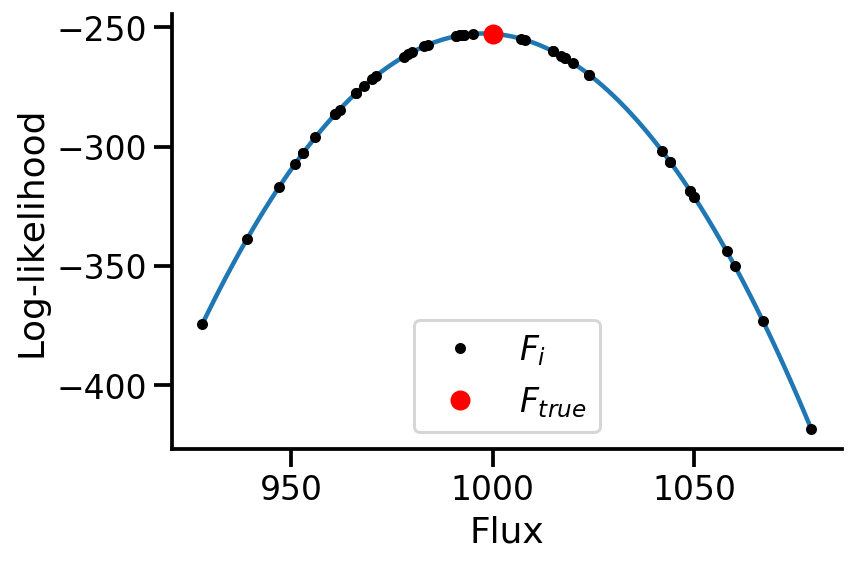

In [148]:
F_range = np.linspace(F.min(), F.max(),100)
plt.plot(F_range, [logL(F_, F) for F_ in F_range])
plt.plot(F, [logL(F_, F) for F_ in F], '.k', label='$F_i$')
plt.plot(F_true, logL(F_true, F), 'or', label='$F_{true}$')
plt.xlabel("Flux")
plt.ylabel("Log-likelihood")
plt.legend()
sns.despine()

We now use *maximum likelihood* and estimate the flux value $F_{\rm est}$ that maximizes the log-likelihood $\log\mathcal{L}$. 

We can find this analytically by solving for the root of the derivative, 

$$
0 = \frac{d\log\mathcal{L}}{d\hat{F}}
\\ =
-\frac{1}{2} \sum_{i=1}^N -2\frac{F_i - \hat{F}}{e_i^2}
\\ =
\sum_{i=1}^N \frac{F_i - \hat{F}}{e_i^2}
$$

Remember that $e_i = \sqrt{F_i}$, so

$$
0 = 
\sum_{i=1}^N \frac{F_i }{F_i} - \sum_{i=1}^N \frac{\hat{F}}{F_i} 
\\ =
N - \hat{F} \sum_{i=1}^N \frac{1}{F_i} 
\\ \Rightarrow
F_{\rm est}  = \frac{N}{\sum_{i=1}^N \frac{1}{F_i}}
$$
Therefore, the estimate $F_{\rm est}$ is the *harmonic mean*!

F_true = 1000 
F_est = 997.679324193871


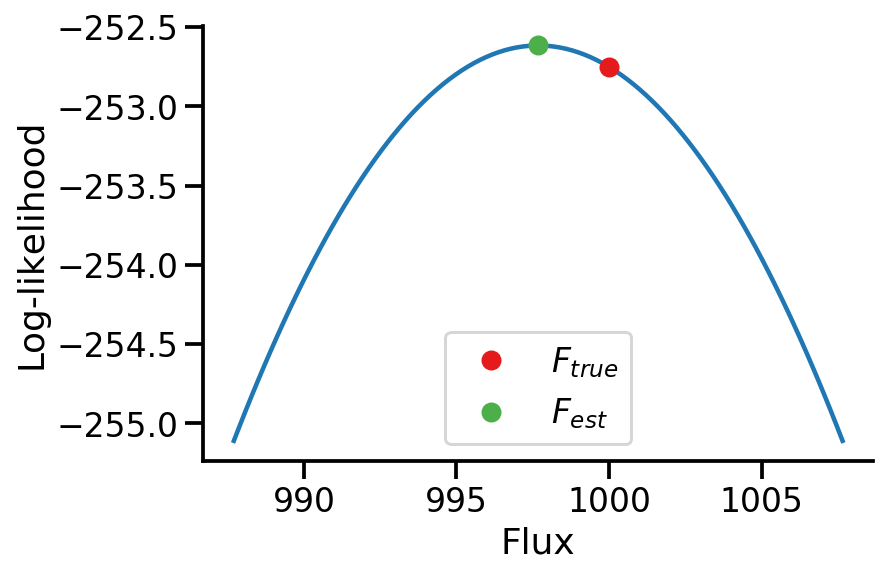

In [281]:
F_est = scipy.stats.hmean(F) # = N / (1/F).sum()
print("F_true = {} \nF_est = {}".format(F_true, F_est))

F_range = np.linspace(F_est*0.99, F_est*1.01,100)
plt.plot(F_range, [logL(F_, F) for F_ in F_range])
plt.plot(F_true, logL(F_true, F), 'o', color=red, label='$F_{true}$')
plt.plot(F_est, logL(F_est, F), 'o', color=green, label='$F_{est}$')
plt.xlabel("Flux")
plt.ylabel("Log-likelihood")
plt.legend()
sns.despine()

The [Cramér–Rao bound](https://en.wikipedia.org/wiki/Cramér–Rao_bound) provides a lower bound for the precision of this estimate

$$
V(F_{\rm est}) \ge \frac{1}{\mathcal{I}}
$$

where $\mathcal{I}$ is Fisher information, defined as:
$$
\mathcal{I} = -\mathbf{E}\Big[\frac{d^2\log\mathcal{L}}{d\hat{F}^2} \mid \hat{F}\Big]
$$

So, we have
$$
\frac{d\log\mathcal{L}}{d\hat{F}}  = N-\hat{F}\sum_{i=1}^N{\frac{1}{F_i}} \Rightarrow \\
\frac{d^2\log\mathcal{L}}{d\hat{F}^2}  = -\sum_{i=1}^N{\frac{1}{F_i}} \Rightarrow \\
\mathcal{I} = \sum_{i=1}^N{\frac{1}{F_i}} \Rightarrow \\
V(F_{\rm est}) \ge \frac{1}{\sum_{i=1}^N{\frac{1}{F_i}}} \Rightarrow \\
\sigma_{est} \ge \frac{1}{\sqrt{\sum_{i=1}^N{\frac{1}{F_i}}}}
$$

F_true = 1000 
F_est = 997.679324193871 +/- 4.4669437520386825


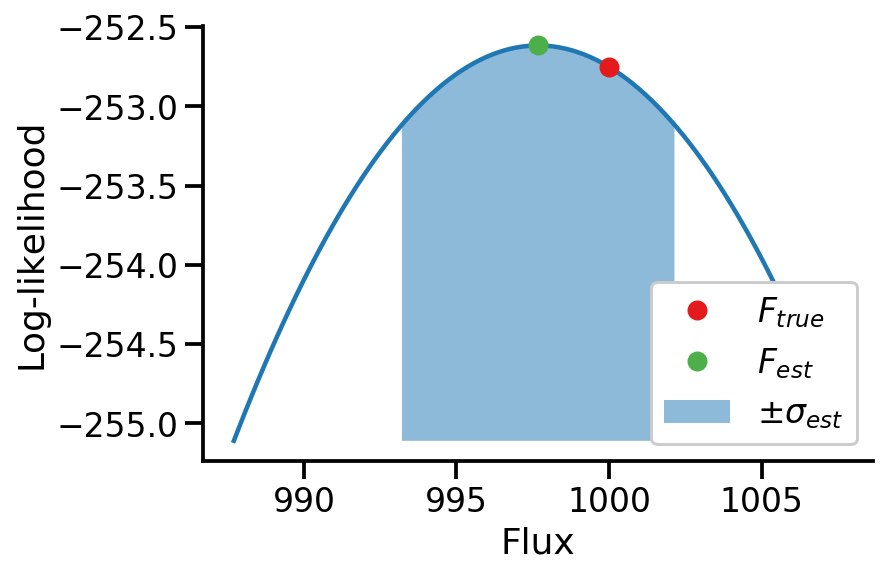

In [285]:
σ_est = ((1/F).sum())**(-0.5)
print("F_true = {} \nF_est = {} +/- {}".format(
    F_true, F_est, σ_est))

F_range = np.linspace(F_est*0.99, F_est*1.01,100)
plt.plot(F_range, [logL(F_, F) for F_ in F_range])
plt.plot(F_true, logL(F_true, F), 'o', color=red, label='$F_{true}$')
plt.plot(F_est, logL(F_est, F), 'o', color=green, label='$F_{est}$')

F_range = np.linspace(F_est-σ_est, F_est+σ_est)
plt.fill_between(F_range, logL(F_est*0.99, F), [logL(F_, F) for F_ in F_range], alpha=0.5, label='$\pm \sigma_{est}$')
plt.xlabel("Flux")
plt.ylabel("Log-likelihood")
plt.legend(loc='lower right', framealpha=1)
sns.despine()

## Bayesian approach

In the Bayesian approach, we want to compute the  posterior distribution of the model parameter
$$
P(F_{\rm true} \mid D),
$$
which reflects our knowledge or beliefe on the parameter $F_{\rm true}$.

This is a one-dimensional problem, so we can work with a direct approach; that won't work with multi-dimensional problems, and therefore it is common to use sampling methods such as _Markov chain Monte Carlo_, or _MCMC_.

We start by defining Python functions for the prior
$$
P(\hat{F}),
$$
the likelihood
$$
P(D \mid \hat{F}),
$$
and the posterior
$$
P(\hat{F} \mid D).
$$

In [614]:
def logPrior(F_est):
    return 1  # flat prior

def logPosterior(F_est, F_data):
    return logPrior(F_est) + logL(F_est, F_data)

We will use the [emcee](https://emcee.readthedocs.io/) package to perform MCMC sampling.

To setup the sampler, we generate some random starting guesses for multiple chains of samples.

In [615]:
ndim = 1  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# we'll start at random locations between 0 and 2000
guesses = 2000 * np.random.rand(nwalkers, ndim)

In [616]:
sampler = emcee.EnsembleSampler(
    nwalkers=nwalkers, 
    ndim=ndim,
    log_prob_fn=logPosterior,
    args=[F]
)
sampler.run_mcmc(
    initial_state=guesses,
    nsteps=nsteps
)

# sampler.chain.shape = (nwalkers, nsteps, ndim)
# discard burn-in points and flatten with ravel()
sample = sampler.chain[:, nburn:, :].ravel()

If this all worked correctly, the array `sample` should contain a series of 50000 points drawn from the posterior. Let's plot them and check.

In [617]:
F_est = sample.mean()
σ_est = sample.std()

print("F_true = {} \nF_est = {} +/- {}".format(
    F_true, F_est, σ_est))

F_true = 1000 
F_est = 997.6402683205047 +/- 4.495183699281103


Before examining the posterior distribution, lets look at the trace plot, which shows:
1. the posterior distributions for each chain
1. the samples for each chain -- the $\mu$ sample values across time.

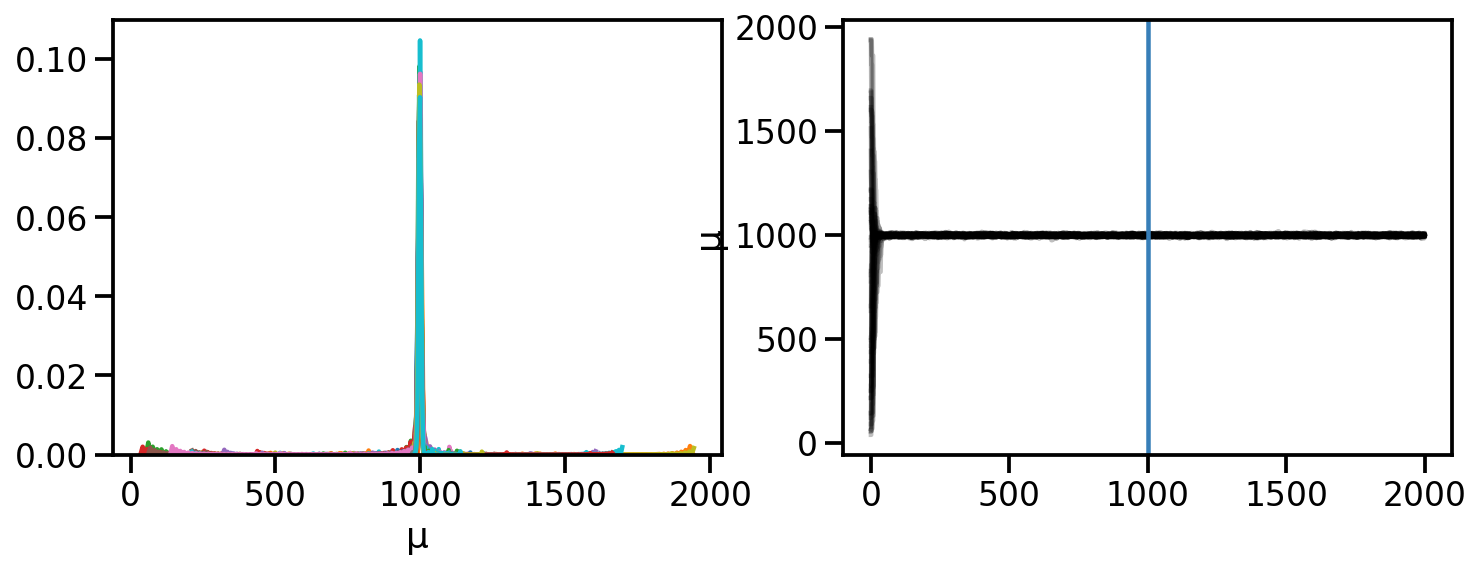

In [643]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i in range(50):
    sns.kdeplot(sampler.chain[i,:,0], ax=axes[0])
axes[0].set_xlabel('μ')

ax = axes[1]
ax.plot(sampler.chain[:,:,0].T, color='k', alpha=0.25);
ax.axvline(nburn, color=blue)
ax.set_ylabel('μ');

You can see here why we need to remove the initial `nburn` samples (or maybe less of them). 

Now we can plot the posterior distribution:

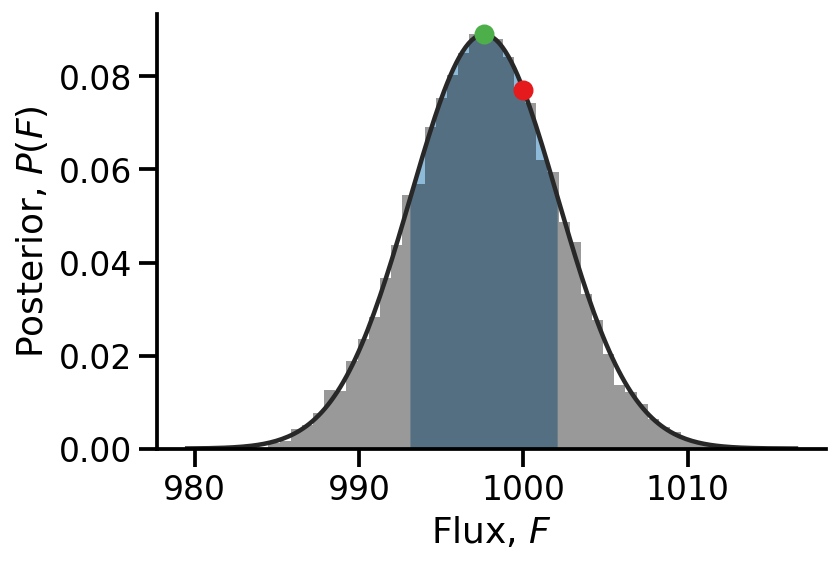

In [315]:
sns.distplot(sample, bins=50, color='k', kde=False, fit=scipy.stats.norm)

norm = scipy.stats.norm(*scipy.stats.norm.fit(sample))

plt.plot(F_true, norm.pdf(F_true), 'o', color=red)
plt.plot(F_est, norm.pdf(F_est), 'o', color=green)
F_range = np.linspace(F_est-σ_est, F_est+σ_est)
plt.fill_between(F_range, 0, [norm.pdf(F_) for F_ in F_range], alpha=0.5, label='$\pm \sigma_{est}$')

plt.xlabel("Flux, $F$")
plt.ylabel("Posterior, $P(F)$")
sns.despine()

For this simple problem, both approaches yield the same result, more or less.

# Complex model for photon count

We now assume that the light source is dynamic and stochastic (e.g. Quasar).

Note the model parameters as $\theta = (\mu, \sigma)$ where $\mu$ is the mean value and $\sigma$ is the standard deviation of the photon emission, regardless of measuring noise.
Therefore the model is
$$
P(F_{\rm true}=F) = \sim \frac{1}{\sqrt{2 \pi \sigma^2}} \exp{\big[\frac{-(F-\mu)^2}{2\sigma^2}\big]}
$$

We generate the data like so:

In [320]:
# for reproducibility
np.random.seed(42)
# we'll use more samples for the complex model
N = 100  
# parameters stochastic flux model
μ_true, σ_true = 1000, 15  
θ_true = (μ_true, σ_true)
# (unknown) true flux
F_true = scipy.stats.norm(μ_true, σ_true).rvs(N)  
# observed flux: true flux plus Poisson errors
F = scipy.stats.poisson(F_true).rvs()  
# root-N error, as above
e = np.sqrt(F)  

## Frequentist approach

The likelihood function is now

$$
\mathcal{L}(\theta~|~D) = 
\prod_{i=1}^N \frac{1}{\sqrt{2\pi(\sigma^2 + e_i^2)}}\exp[\frac{-(F_i - \mu)^2}{2(\sigma^2 + e_i^2)}]
$$

To find an analytic solution to the maximum likelihood problem we differentiate and set to zero to get
$$
\mu_{\rm est} = \frac{\sum_{i=1}^{N}{\frac{F_i}{\sigma^2+e_i^2}}}{\sum_{i=1}^{N}{\frac{1}{\sigma^2+e_i^2}}}.
$$
However, we see that the estimate for $\mu$ depends on $\sigma$ (and vice versa) so we cannot use a straightforward analytic method.

Instead, we will use a numerical optimization routine from `scipy.optimize`.

In [322]:
def logL(θ, F):
    μ, σ = θ
    e = F**0.5
    return -0.5 * (np.log(2 * np.pi * (σ ** 2 + e ** 2))
                         + (F - μ) ** 2 / (σ ** 2 + e ** 2)).sum()
logL(θ_true, F)

-503.223428772118

Note that optimization routines usually _minimize_ rather than _maximize_, so we use the negative log-likelihood.

In [324]:
def negLogL(θ, F):
    return -logL(θ, F)

negLogL(θ_true, F)

503.223428772118

In [327]:
θ_guess = (900, 5)
θ_est = scipy.optimize.fmin(
    func=negLogL, 
    x0=θ_guess, 
    args=(F,)
)
μ_est, σ_est = θ_est
print("μ_true = {} \tμ_est = {:.2f}\nσ_true = {}\tσ_est = {:.2f}".format(
    μ_true, μ_est, σ_true, σ_est))

Optimization terminated successfully.
         Current function value: 502.839505
         Iterations: 58
         Function evaluations: 114
μ_true = 1000 	μ_est = 999.23
σ_true = 15	σ_est = 19.35


We can plot the log-likelihood surface (since there are only two parameters).

You can see that changing $\sigma$ doesn't have a strong effect on the log-likelihood compared to changing $\mu$. So our $\sigma$ estimate is not as confident as our $\mu$ estimate.

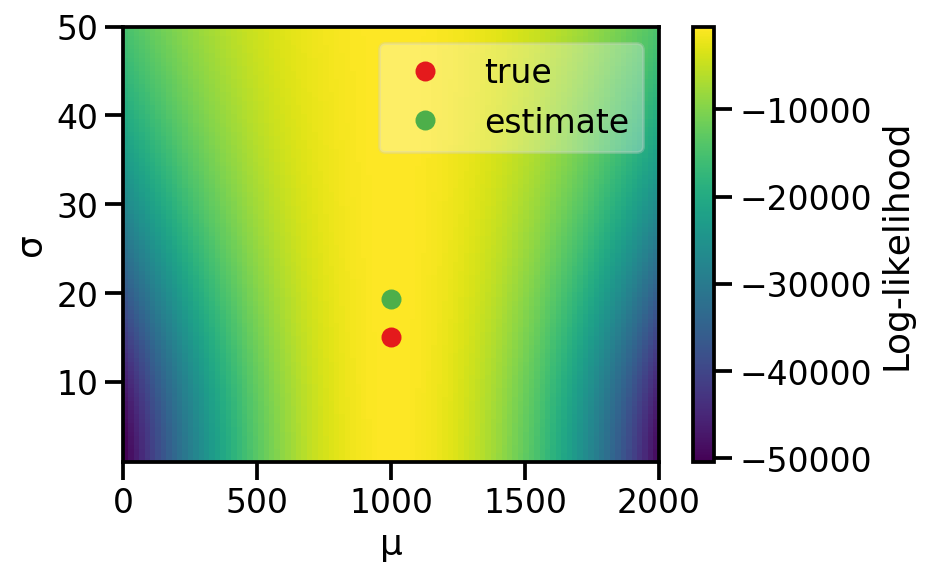

In [349]:
μ_range = np.linspace(0, 2000, 100)
σ_range = np.linspace(1, 50, 101)
logL_ = np.array([
    [logL((μ_, σ_), F) for μ_ in μ_range]
    for σ_ in σ_range
])

plt.pcolormesh(μ_range, σ_range, logL_)
plt.colorbar(label='Log-likelihood')
plt.plot(μ_true, σ_true, 'o', color=red, label='true')
plt.plot(μ_est, σ_est, 'o', color=green, label='estimate')
plt.xlabel('μ')
plt.ylabel('σ')
plt.legend(framealpha=0.3);

There are several analytic methods to quantify the uncertainty in the parameter estimations.

Instead, we will use the bootstrap method, in which we estimate the parameters from many resamples of the data.

In [389]:
n_resamples = 1000
resamples = np.random.choice(F, size=(n_resamples, N))

In [390]:
θ_bootstrap = np.array([ # parallelize this step for greater efficiency
    scipy.optimize.fmin(
        func=negLogL, 
        x0=θ_guess, 
        args=(sample,),
        disp=0 # no prints
    )
    for sample in resamples
])
μ_bootstrap, σ_bootstrap = θ_bootstrap.T

We can inspect the distributions of the estimations to see how far the true and estimated values are compared to all boostrap estimations.

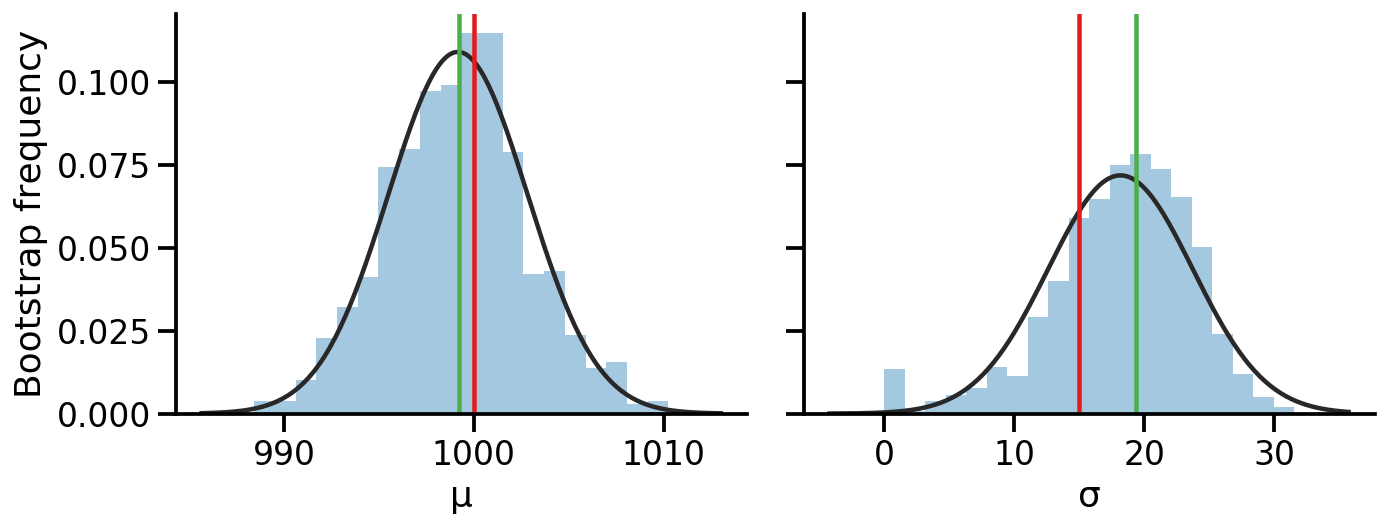

In [391]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
sns.distplot(μ_bootstrap, bins=20, fit=scipy.stats.norm, kde=False, ax=axes[0])
sns.distplot(σ_bootstrap, bins=20, fit=scipy.stats.norm, kde=False, ax=axes[1])

axes[0].axvline(μ_true, color=red)
axes[0].axvline(μ_est, color=green)
axes[1].axvline(σ_true, color=red)
axes[1].axvline(σ_est, color=green)

axes[0].set(xlabel='μ', ylabel='Bootstrap frequency')
axes[1].set(xlabel='σ')

fig.tight_layout()
sns.despine()

It is also important to check if there is discernable correlation between $\mu$ and $\sigma$ estimates.

Since the estimates seem to be normally distributed, we can use the Pearson's correlation (otherwise we would use Spearman's correlation).
The computed P-value is the probability that an uncorrelated dataset generates a correlation at least as extreme as the one computed for this dataset. If the P-value is small enough then we can reject the null hypothesis that the data is uncorrelated.

Pearson correlation: 0.0019, P-value: 0.95


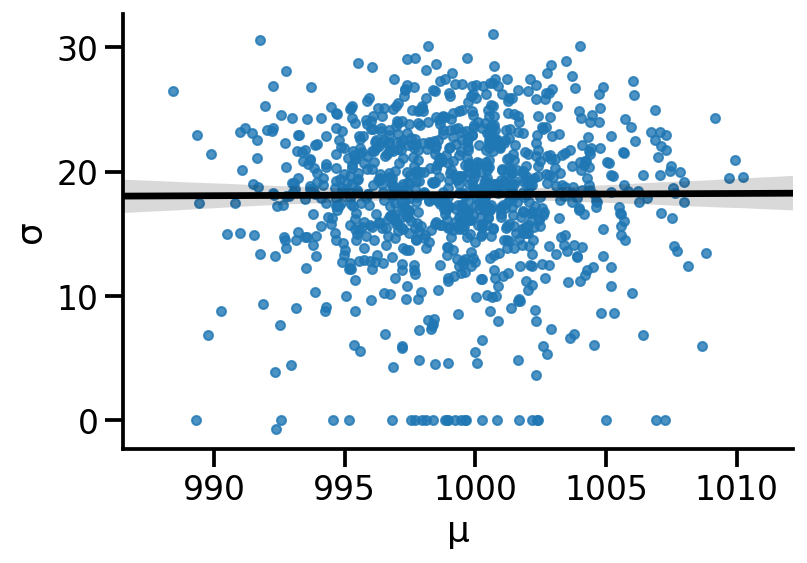

In [413]:
r, pvalue = scipy.stats.spearmanr(μ_bootstrap, σ_boostrap)
print("Pearson correlation: {:.2g}, P-value: {:.2g}".format(r, pvalue))

sns.regplot(μ_bootstrap, σ_boostrap, marker='.',
            line_kws=dict(color='k'))
plt.xlabel('μ')
plt.ylabel('σ')
sns.despine()

The plot shows all the $(\mu, \sigma)$ bootstrap pairs, with a regression line that seems very flat -- hence no correlation.

## Bayesian approach

This is very similar to the previous case, with minor modifications to introduce the second parameter $\sigma$.

In [417]:
def logPrior(θ):
    μ, σ = θ
    # sigma needs to be positive.
    if σ <= 0:
        return -np.inf
    else:
        return 0 # flat prior when σ>0

def logPosterior(θ, F):
    return logPrior(θ) + logL(θ, F)

In [600]:
ndim, nwalkers = 2, 50
nsteps, nburn = 2000, 1000

guesses = np.random.rand(nwalkers, ndim)
guesses[:, 0] *= 2000  # start mu between 0 and 2000
guesses[:, 1] *= 20    # start sigma between 0 and 20

sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior, args=[F])
sampler.run_mcmc(guesses, nsteps)

# sampler.chain.shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, 2)

In [601]:
μ_sample, σ_sample = sample[:,0], sample[:,1]
μ_est, σ_est = μ_sample.mean(), (σ_sample).mean()

print("μ_true = {} \tμ_est = {:.2f}\nσ_true = {}\tσ_est = {:.2f}".format(
    μ_true, μ_est, σ_true, σ_est))

μ_true = 1000 	μ_est = 999.28
σ_true = 15	σ_est = 18.94


These estimates are very similar to those of the frequentist approach.

Lets plot the posterior distribution. 
To do that, we estimate the joint distribution using a kernel density estimator.

In [602]:
n = 100
kde = scipy.stats.gaussian_kde([μ_sample, σ_sample])
μ_range = np.linspace(980, 1020, n)
σ_range = np.linspace(0, 40, n)
θ_range = np.array([[(μ, σ) for μ in μ_range] for σ in σ_range])
θ_range = θ_range.reshape((-1, 2)).T
density = kde(θ_range)
density = density.reshape((n, n))

We plot the marginal distributions of $\mu$ and $\sigma$ on the diagonal as histograms, with normal distributions fitted over them.

We also plot the joint distributions, once as contours with the samples as dots, and once with a colored plot where yellow is high density and purple is low density.

In all plots, the red and green markers show the true and sample mean of the parameters.

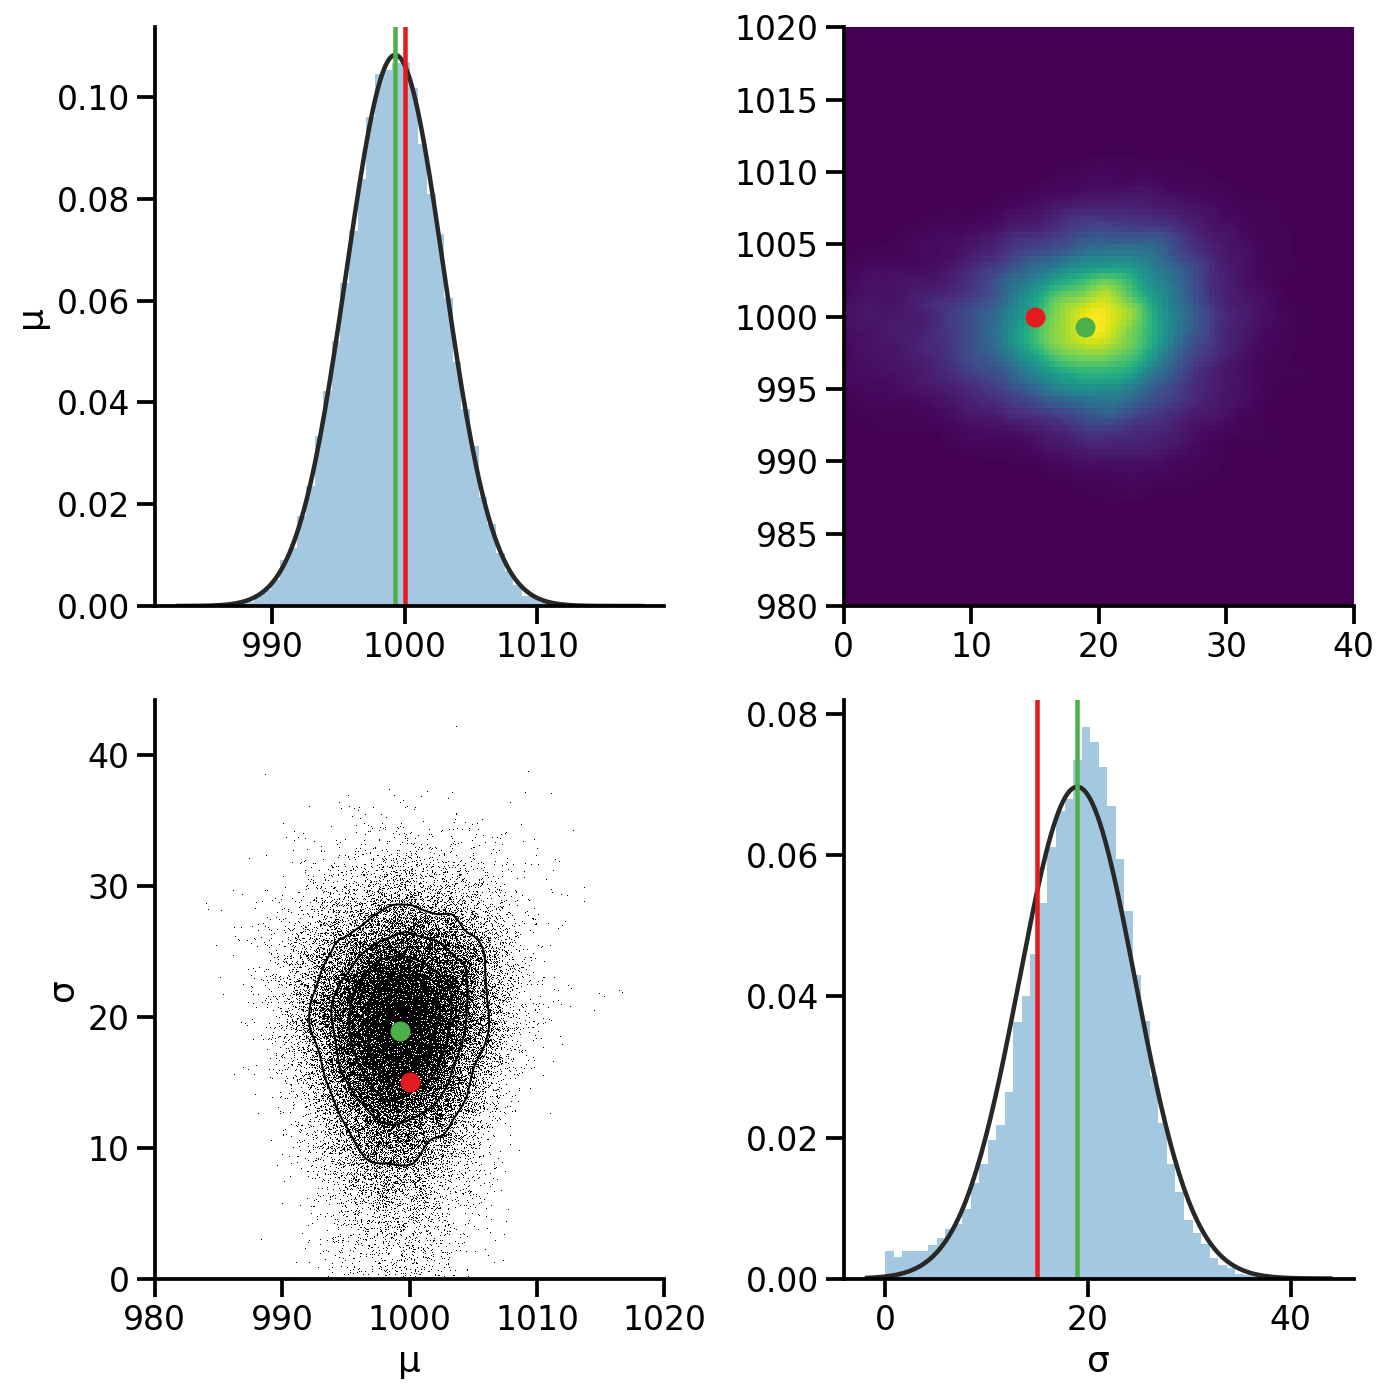

In [603]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# marginal
sns.distplot(μ_sample, bins=50, fit=scipy.stats.norm, kde=False, ax=axes[0,0])
sns.distplot(σ_sample, bins=50, fit=scipy.stats.norm, kde=False, ax=axes[1,1])

axes[0,0].axvline(μ_true, color=red)
axes[0,0].axvline(μ_est, color=green)
axes[1,1].axvline(σ_true, color=red)
axes[1,1].axvline(σ_est, color=green)

# joint
axes[0,1].pcolormesh(σ_range, μ_range, density.T)
axes[0,1].plot(σ_true, μ_true, color=red, marker='o')
axes[0,1].plot(σ_est, μ_est, color=green, marker='o')

axes[1,0].plot(μ_sample, σ_sample, ',k')
axes[1,0].plot(μ_true, σ_true, color=red, marker='o')
axes[1,0].plot(μ_est, σ_est, color=green, marker='o')
axes[1,0].contour(μ_range, σ_range, density, colors='k', linewidths=1)


axes[0,0].set(ylabel='μ')
axes[0,1].set()
axes[1,0].set(xlabel='μ', ylabel='σ')
axes[1,1].set(xlabel='σ')


fig.tight_layout()
sns.despine()

You can see that the marginal posterior of $\mu$ fits a normal distribution very nicely, but the posterior of $\sigma$ not so much, which makes sense, because it is bounded by 0 on the left. This might also bias our estimate, which is made with a mean.

We can also get a similar plot using the [corner](http://corner.readthedocs.io) package.

Here, the contours on the joint plot show one and two standard deviations (of a gaussian) to demonstrate confidence regions. This demonstrates that the truth is just on the edge of the confidence region.

In [604]:
from corner import corner 

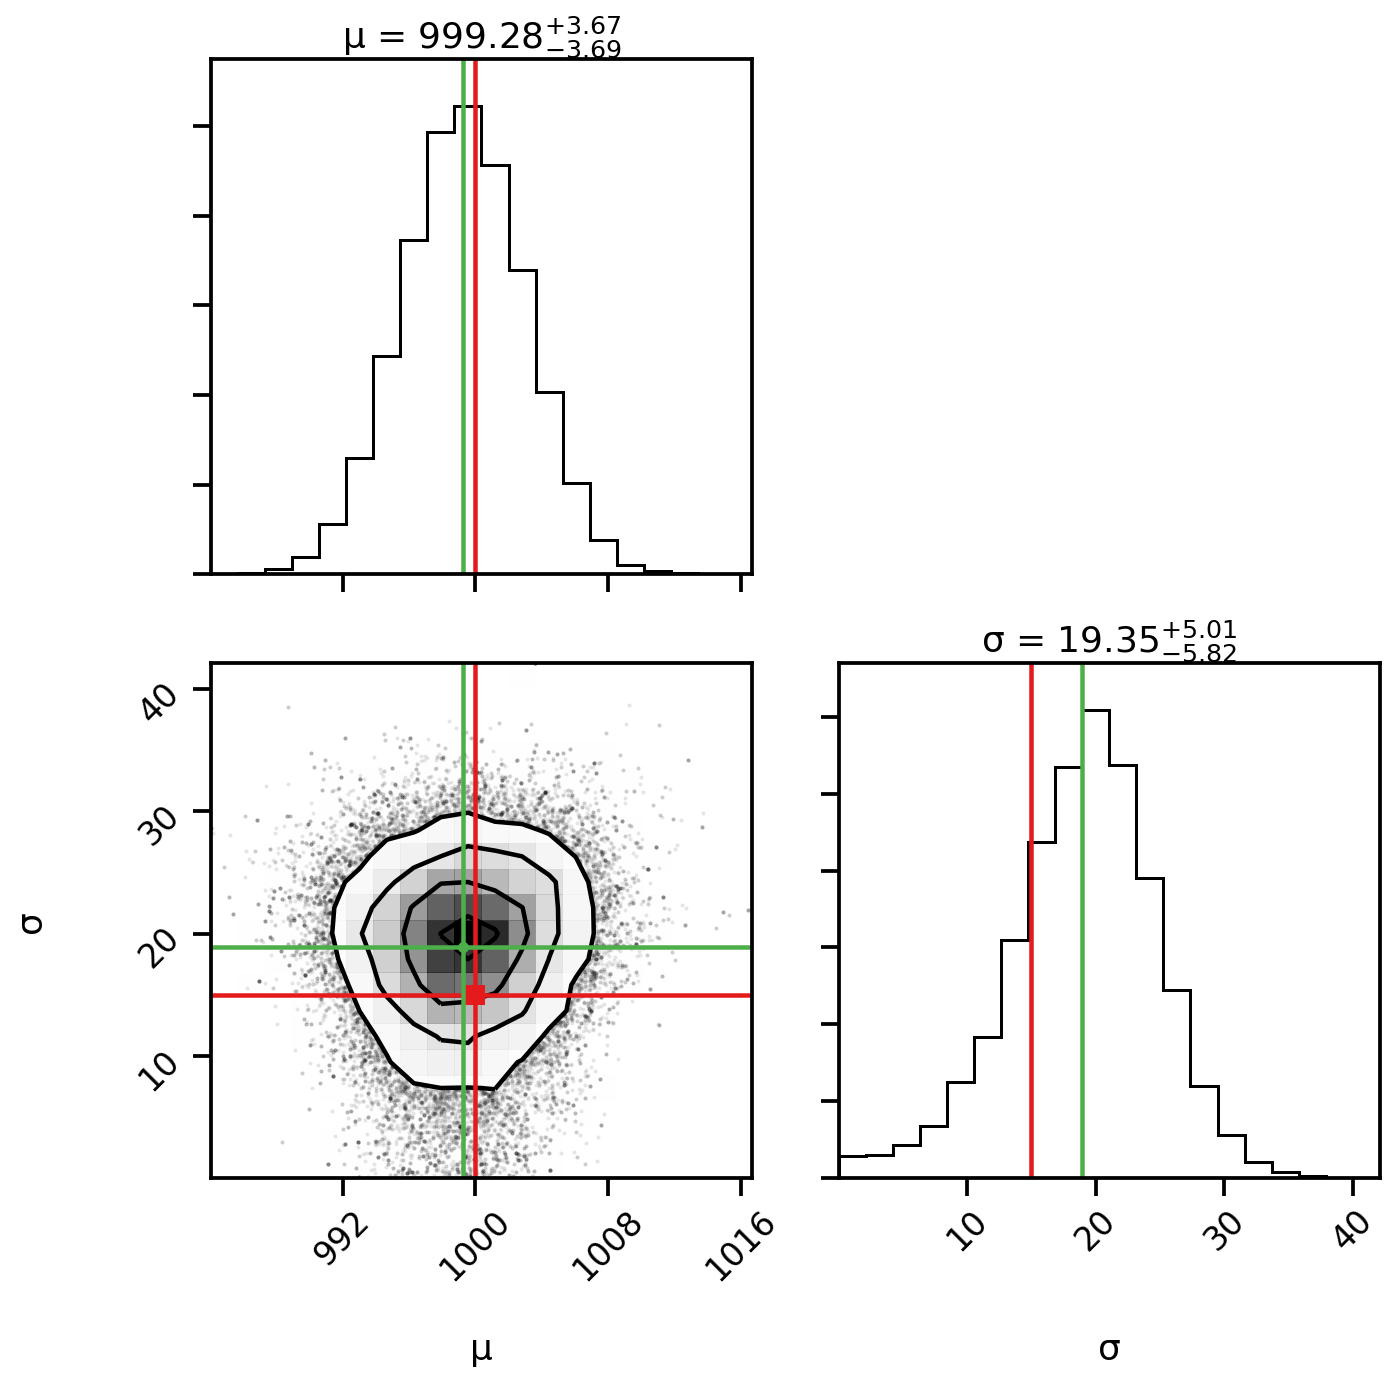

In [605]:
θ_sample = np.array([μ_sample, σ_sample]).T
cor = corner(θ_sample, 
    labels=['μ', 'σ'],
    truths=[μ_true, σ_true],
    truth_color=red,
    show_titles=True,
)
cor.axes[0].axvline(μ_est, color=green)
cor.axes[3].axvline(σ_est, color=green)
cor.axes[2].axvline(μ_est, color=green)
cor.axes[2].axhline(σ_est, color=green)
cor.axes[2].plot(μ_est, σ_est, '.', color=green)
cor.set_size_inches(10, 10)
plt.tight_layout()

[Arviz](https://arviz-devs.github.io) is another package for plotting results of Bayesian inference.

In [606]:
import arviz as az

In [607]:
az_data = az.from_emcee(
    sampler, 
    var_names=['μ', 'σ']
)

We can plot the posterior distributions:

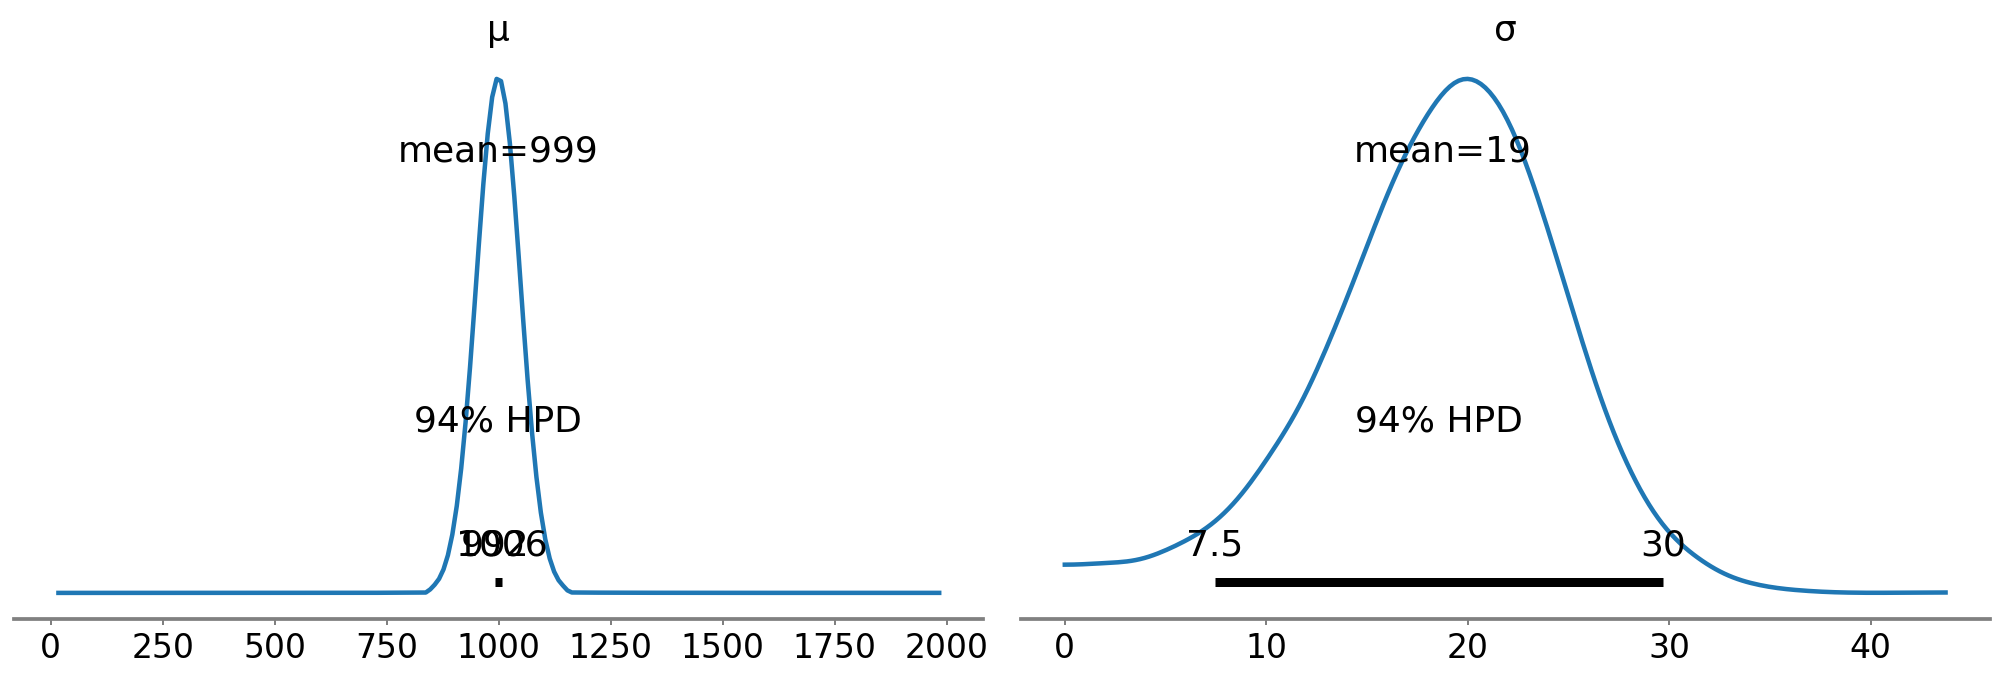

In [608]:
az.plot_posterior(az_data);

An important diagnostic is the trace plot:

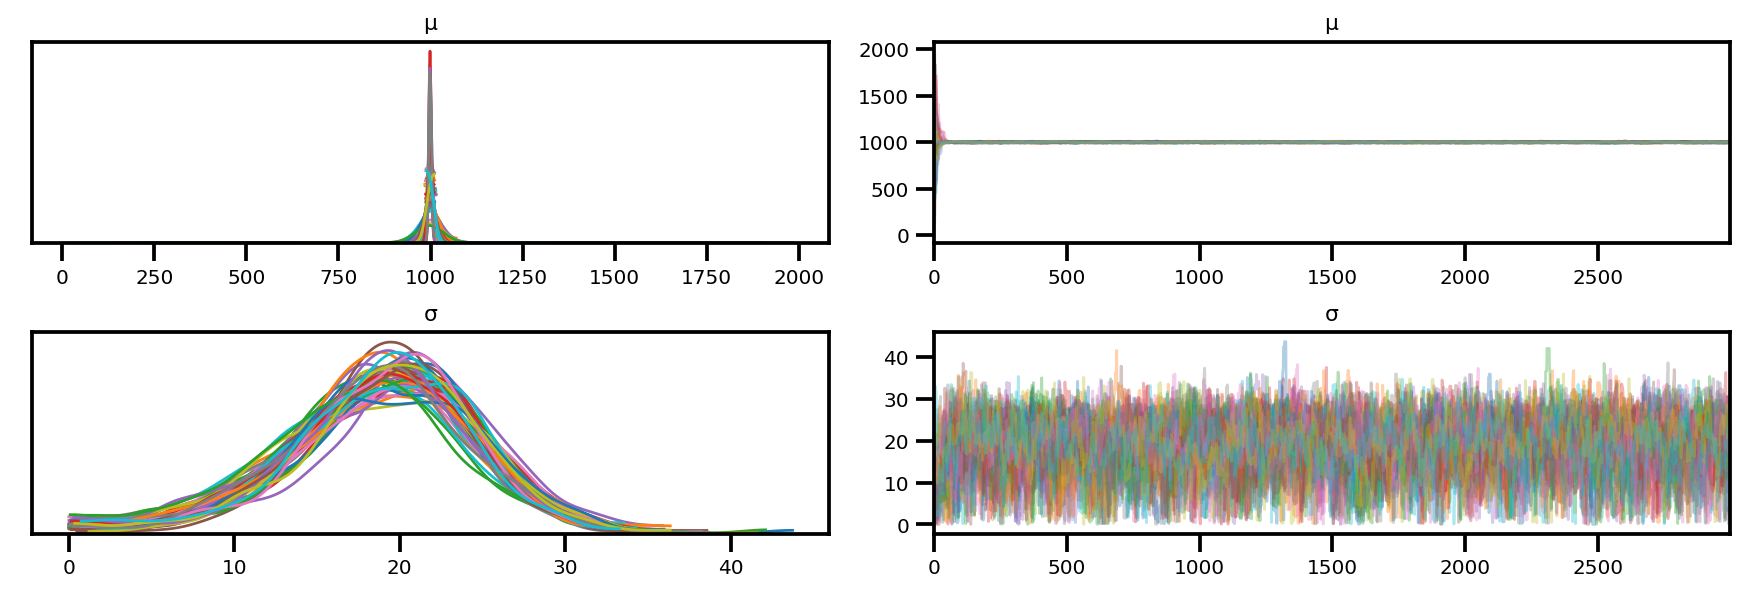

In [609]:
az.plot_trace(az_data);

# References

- Jake VanDerPlas's series of [blog posts on Beysian inference](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Scientific Computing with Python_](https://scicompy.yoavram.com/) course at IDC Herzliya.

The notebook was written using [Python](http://python.org/) 3.6.5.
Dependencies listed in [environment.yml](../environment.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)